# Model Training

train_models.ipynb
- load_data + clean: selección de parcelas.
- call create_spine: [parcela, tstamp, target]
- call features -> train/test dataframe: [parcela, tstamp, feature1....N, target]
- train (hp tuning + feature_selection + cat. encoding) -> save model
- evaluacion -> loggear metrics

In [1]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
sys.path.insert(0,str(Path("../../").resolve()))

from src.load import load_clean_data
from src.load_meteo import load_clean_meteo_data

from src.features import create_spine, generate_target
from src.models import train_test_split, feature_label_split, baseline
from src.features import calculate_climatic_stats_time_window, calculate_week_number, calculates_days_in_phenological_state_current_and_previous

import logging
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error)

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from src.features import attach_meteo_var, attach_parcela_var


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [13]:
def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)), columns=["features", "importance"]
    ).sort_values(by="importance", ascending=True)
    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    return fi, fig, ax

## Load data

In [3]:
DATA_PATH = os.path.join(Path("../").resolve(), "data")
PARCELAS_DATA_PATH = os.path.join(DATA_PATH, "clean_parcelas.parquet")
METEO_DATA_PATH = os.path.join(DATA_PATH, "clean_meteo.parquet")

if not os.path.isfile(PARCELAS_DATA_PATH) or not os.path.isfile(METEO_DATA_PATH):
    df_parcelas = load_clean_data()
    df_meteo = load_clean_meteo_data()

    df_parcelas.to_parquet(PARCELAS_DATA_PATH)
    df_meteo.to_parquet(METEO_DATA_PATH)
else:
    df_parcelas = pd.read_parquet(PARCELAS_DATA_PATH)
    df_meteo = pd.read_parquet(METEO_DATA_PATH)
    print("Datasets loaded.")

Datasets loaded.


## Evaluation defitinion

In [4]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='/home/agrande/zrive-ds-1q24-olive-stage-prediction/src/logs/evaluation.log', 
                    filemode='a')

def evaluate_classification(y_true, y_pred):
    metrics_dict = {}

    try:
        # Basic metrics
        metrics_dict['accuracy'] = accuracy_score(y_true, y_pred)
        metrics_dict['precision_macro'] = precision_score(y_true, y_pred, average='macro',zero_division=0)
        metrics_dict['recall_macro'] = recall_score(y_true, y_pred, average='macro',zero_division=0)
        metrics_dict['f1_macro'] = f1_score(y_true, y_pred, average='macro',zero_division=0)
        metrics_dict['mse'] = mean_squared_error(y_true, y_pred) 

        # Log and print computed metrics
        #logging.info("Computed Metrics: %s", metrics_dict)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        metrics_dict['confusion_matrix'] = cm
        #logging.info("Confusion Matrix:\n%s", cm)

    except Exception as e:
        logging.error("Error computing metrics: %s", str(e))

    for key, value in metrics_dict.items():
        print(f"{key}: {value}\n")
    print("-----------------------------------------------------------------\n")

## Baseline

In [5]:
baseline_parcelas = generate_target(df_parcelas)

baseline_train_df, baseline_test_df = train_test_split(baseline_parcelas, split_year=2021, max_year=2022)
baseline_result = baseline(baseline_train_df, baseline_test_df, 'target')[['codparcela','fecha','target','y_pred']]

In [7]:
baseline_result


,codparcela,fecha,target,y_pred
154178,001-00003-01,2022-06-29,0.0,0.175874
156325,001-00003-01,2022-07-19,0.0,0.175874
158014,001-00003-01,2022-08-02,0.0,0.175874
159003,001-00003-01,2022-08-10,0.0,0.175874
159662,001-00003-01,2022-08-17,0.0,0.175874
...,...,...,...,...
161869,501-00275-02-00,2022-09-07,0.0,0.175874
162880,501-00275-02-00,2022-09-14,0.0,0.175874
163835,501-00275-02-00,2022-09-21,1.0,0.175874
164716,501-00275-02-00,2022-09-28,2.0,0.175874


In [9]:
evaluate_classification(baseline_result['target'],baseline_result['y_pred'].round())

accuracy: 0.6592050762316031

precision_macro: 0.2695155021443662

recall_macro: 0.2555601855481858

f1_macro: 0.2593766865068588

mse: 0.47431039041156253

confusion_matrix: [[9870 1840   44    0    0    0    0]
 [3020 3940  518    0    0    0    0]
 [ 202 1371 1150    0    0    0    0]
 [  13  544  128    0    0    0    0]
 [   1   42    0    0    0    0    0]
 [   0    9    0    0    0    0    0]
 [   0    2    0    0    0    0    0]]

-----------------------------------------------------------------



## Feature engineering

### Generate new features

In [4]:
# Generate meteo stats
# df_meteo_stats_aux = calculate_climatic_stats_time_window(df_meteo,'365D')

# Generate week number
df_parcelas = calculate_week_number(df_parcelas)

# Generate days in phenological state
df_parcelas_days = calculates_days_in_phenological_state_current_and_previous(df_parcelas)

/home/agrande/zrive-ds-1q24-olive-stage-prediction/src/features.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['days_spent'] = df.groupby(['codparcela','campaña'])['fecha'].diff().dt.days
/home/agrande/zrive-ds-1q24-olive-stage-prediction/src/features.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['days_in_current_state'] = df.groupby(['codparcela','campaña','period_id'])['days_spent'].cumsum()
/home/agrande/zrive-ds-1q24-olive-stage-prediction/src/features.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

In [6]:
df_parcelas_days.head(50)

,codparcela,fecha,days_in_current_state,days_in_previous_state
428074,001-00003-01,2019-07-02,NaN,NaN
428075,001-00003-01,2019-07-09,7.0,NaN
428076,001-00003-01,2019-07-17,15.0,NaN
428077,001-00003-01,2019-07-24,22.0,NaN
428078,001-00003-01,2019-07-31,29.0,NaN
428079,001-00003-01,2019-08-06,35.0,NaN
428080,001-00003-01,2019-08-13,42.0,NaN
428081,001-00003-01,2019-08-20,49.0,NaN
428082,001-00003-01,2019-08-28,57.0,NaN
428083,001-00003-01,2019-09-10,70.0,NaN


#### Tests

In [3]:
DATA_PATH = os.path.join(Path("../").resolve(), "data")
PARCELAS_DATA_PATH = os.path.join(DATA_PATH, "clean_parcelas.parquet")
METEO_DATA_PATH = os.path.join(DATA_PATH, "clean_meteo.parquet")

df_meteo = pd.read_parquet(METEO_DATA_PATH)

In [4]:
'''
METEO_COLUMNS = ['FAPAR','GNDVI','LST','NDVI','NDWI','SAVI','SIPI','SSM']

def calculate_climatic_stats_time_window(meteo_df: pd.DataFrame, rolling_window: str = '30D') -> pd.DataFrame:    
    # Work with necessary columns only
    columns_to_use = ['codparcela', 'fecha'] + METEO_COLUMNS
    meteo_df = meteo_df[columns_to_use]
    
    meteo_df.sort_values(by=['codparcela', 'fecha'], inplace=True)

    # Set 'fecha' as index
    meteo_df.set_index('fecha', inplace=True)

    # Calculate descriptive statistics using minimal necessary operations
    # .agg can be adjusted to compute only needed statistics to improve performance
    stats = meteo_df.groupby('codparcela').rolling(rolling_window).agg(['count','mean','std','min','median','max'])
    stats.columns = ['_'.join(col).strip() + '_' + rolling_window for col in stats.columns]

    # Reset index to make 'codparcela' and 'fecha' columns again
    stats.reset_index(inplace=True)

    return stats
'''

In [5]:
df_meteo_stats_aux = calculate_climatic_stats_time_window(df_meteo,'365D')

/tmp/ipykernel_128152/2646243341.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_df.sort_values(by=['codparcela', 'fecha'], inplace=True)


In [6]:
METEO_DATA_PATH = os.path.join(DATA_PATH, "meteo_stats_365d.parquet")
df_meteo_stats_aux.to_parquet(METEO_DATA_PATH)

### NAN values

In [24]:
PHENOLOGICAL_STATE_COLS = [f"estado_fenologico_{i}" for i in range(14, 0, -1)]

def analyse_nulls(df_:pd.DataFrame, columns_to_analyse:list):
    study_cols = {}
    for column in df_[columns_to_analyse]:
        if column not in PHENOLOGICAL_STATE_COLS:
            # Calcular el porcentaje de valores nulos
            null_perc = df_[column].isnull().sum() / len(df_) * 100
            # Calcular estadísticas descriptivas
            stats = df_[column].describe()

            if null_perc <= 100:
                study_cols[column] = null_perc
            
            # Imprimir la información de la columna
            print(f"Columna: {column}")
            print(f"Porcentaje de valores nulos: {null_perc:.2f}%")
            print("Estadísticas descriptivas:")
            print(stats)
            print('------------------------------------------------------------------------------------------------------------------------------')
    return study_cols

In [27]:
analyse_nulls(df_parcelas,df_parcelas.select_dtypes(include=['number']).columns)

Columna: campaña
Porcentaje de valores nulos: 0.00%
Estadísticas descriptivas:
count    169168.000000
mean       2019.926056
std           1.379075
min        2017.000000
25%        2019.000000
50%        2020.000000
75%        2021.000000
max        2023.000000
Name: campaña, dtype: float64
------------------------------------------------------------------------------------------------------------------------------
Columna: poligono
Porcentaje de valores nulos: 0.00%
Estadísticas descriptivas:
count     169168.0
mean     23.028717
std      31.121338
min            1.0
25%            6.0
50%           13.0
75%           29.0
max          504.0
Name: poligono, dtype: Float64
------------------------------------------------------------------------------------------------------------------------------
Columna: parcela
Porcentaje de valores nulos: 0.00%
Estadísticas descriptivas:
count      169168.0
mean     126.337942
std       351.85712
min             1.0
25%            20.0
50%        

{'campaña': 0.0,
 'poligono': 0.0,
 'parcela': 0.0,
 'recinto': 0.01241369526151518,
 'subrecinto': 25.68511775276648,
 'porcentaje_floracion': 93.28123522179136,
 '102_coordenada_x_(utm)': 0.1324127494561619,
 '103_coordenada_y_(utm)': 0.1324127494561619,
 '104_altitud_(m)': 52.693771871748794,
 '201_superf_cultivada_en_la_parcela_agrícola_(ha)': 1.483141019578171,
 '202_pendiente_(%)': 34.431452757022605,
 '302_densidad_(plantas_ha)': 5.353849427787762,
 '303_nº_pies_por_árbol': 22.922183864560676,
 '305_diámetro_de_copa_(m)': 83.61806015322047,
 '317_%_superficie_ocupada_variedad_secundaria': 96.05658280525867,
 '306_altura_de_copa_(m)': 86.86217251489643,
 'estado_mayoritario': 0.0}

In [34]:
analyse_nulls(df_parcelas,df_parcelas.select_dtypes(include=['category','object']).columns)

Columna: codparcela
Porcentaje de valores nulos: 0.00%
Estadísticas descriptivas:
count              169168
unique               1876
top       007-00018-01-01
freq                  298
Name: codparcela, dtype: object
------------------------------------------------------------------------------------------------------------------------------
Columna: 105_comarca
Porcentaje de valores nulos: 0.10%
Estadísticas descriptivas:
count     168993
unique        56
top       ESTEPA
freq       17845
Name: 105_comarca, dtype: object
------------------------------------------------------------------------------------------------------------------------------
Columna: 203_orientación
Porcentaje de valores nulos: 69.89%
Estadísticas descriptivas:
count      50938
unique        23
top       2 - NE
freq        6348
Name: 203_orientación, dtype: object
------------------------------------------------------------------------------------------------------------------------------
Columna: 204_textura_del

{'codparcela': 0.0,
 '105_comarca': 0.10344746051262649,
 '203_orientación': 69.88910432233047,
 '204_textura_del_suelo': 59.71578549134588,
 '206_secano_/_regadío': 1.9802799583845645,
 '211_utilización_de_cubierta_vegetal': 18.599853400170243,
 '212_tipo_de_cubierta_vegetal': 45.06644282606639,
 '214_cultivo_asociado/otro_aprovechamiento': 91.12716352974559,
 '301_marco_(m_x_m)': 3.589922443961033,
 '304_formación': 76.23900501276837,
 '308_variedad_principal': 8.079542230209023,
 '311_fecha_de_plantación_variedad_principal': 0.05024590939184716,
 '208_riego:_procedencia_del_agua': 0.05024590939184716,
 '209_riego:_calidad_del_agua': 0.05024590939184716,
 '313_variedad_secundaria': 83.7735269081623,
 '107_zona_homogénea': 0.05024590939184716,
 '120_zona_biológica_raif': 0.658516977206091,
 '401_estación_climática_asociada': 0.05024590939184716,
 '402_sensor_climático_asociado': 67.95611463160881,
 '207_riego:_sistema_usual_de_riego': 0.05024590939184716,
 '108_u_h_c_a_la_que_pertenec

## ML pipeline

In [7]:
### I won't use columns with more than 80% of nulls
PHENOLOGICAL_STATE_COLS = [f"estado_fenologico_{i}" for i in range(14, 0, -1)]

parcelas_numerical_cols = ['campaña','porcentaje_floracion','102_coordenada_x_(utm)',
        '103_coordenada_y_(utm)', '104_altitud_(m)','201_superf_cultivada_en_la_parcela_agrícola_(ha)',
        '202_pendiente_(%)', '302_densidad_(plantas_ha)', '303_nº_pies_por_árbol',
        '305_diámetro_de_copa_(m)','317_%_superficie_ocupada_variedad_secundaria',
        '306_altura_de_copa_(m)', 'estado_mayoritario']

parcelas_categorical_cols = ['codparcela', '105_comarca', '203_orientación', '204_textura_del_suelo',
       '206_secano_/_regadío', '211_utilización_de_cubierta_vegetal',
       '212_tipo_de_cubierta_vegetal',
       '214_cultivo_asociado/otro_aprovechamiento', '301_marco_(m_x_m)',
       '304_formación', '308_variedad_principal',
       '311_fecha_de_plantación_variedad_principal',
       '208_riego:_procedencia_del_agua', '209_riego:_calidad_del_agua',
       '313_variedad_secundaria', '107_zona_homogénea',
       '120_zona_biológica_raif', '401_estación_climática_asociada',
       '402_sensor_climático_asociado', '207_riego:_sistema_usual_de_riego',
       '108_u_h_c_a_la_que_pertenece',
       '316_fecha_de_plantación_variedad_secundaria',
       '315_patrón_variedad_secundaria', '310_patrón_variedad_principal',
       '411_representa_a_la_u_h_c_(si/no)',
       '109_sistema_para_el_cumplimiento_gestión_integrada']

meteo_numerical_cols = ['lat', 'lon', 'FAPAR', 'GNDVI', 'LST',
                         'NDVI', 'NDWI', 'SAVI', 'SIPI', 'SSM']

label_col = 'target'

### Correlation matrix - HACERLA CON TODAS LAS VARIABLES NUMÉRICAS DE CLIMA Y PARCELAS Y EL TARGET

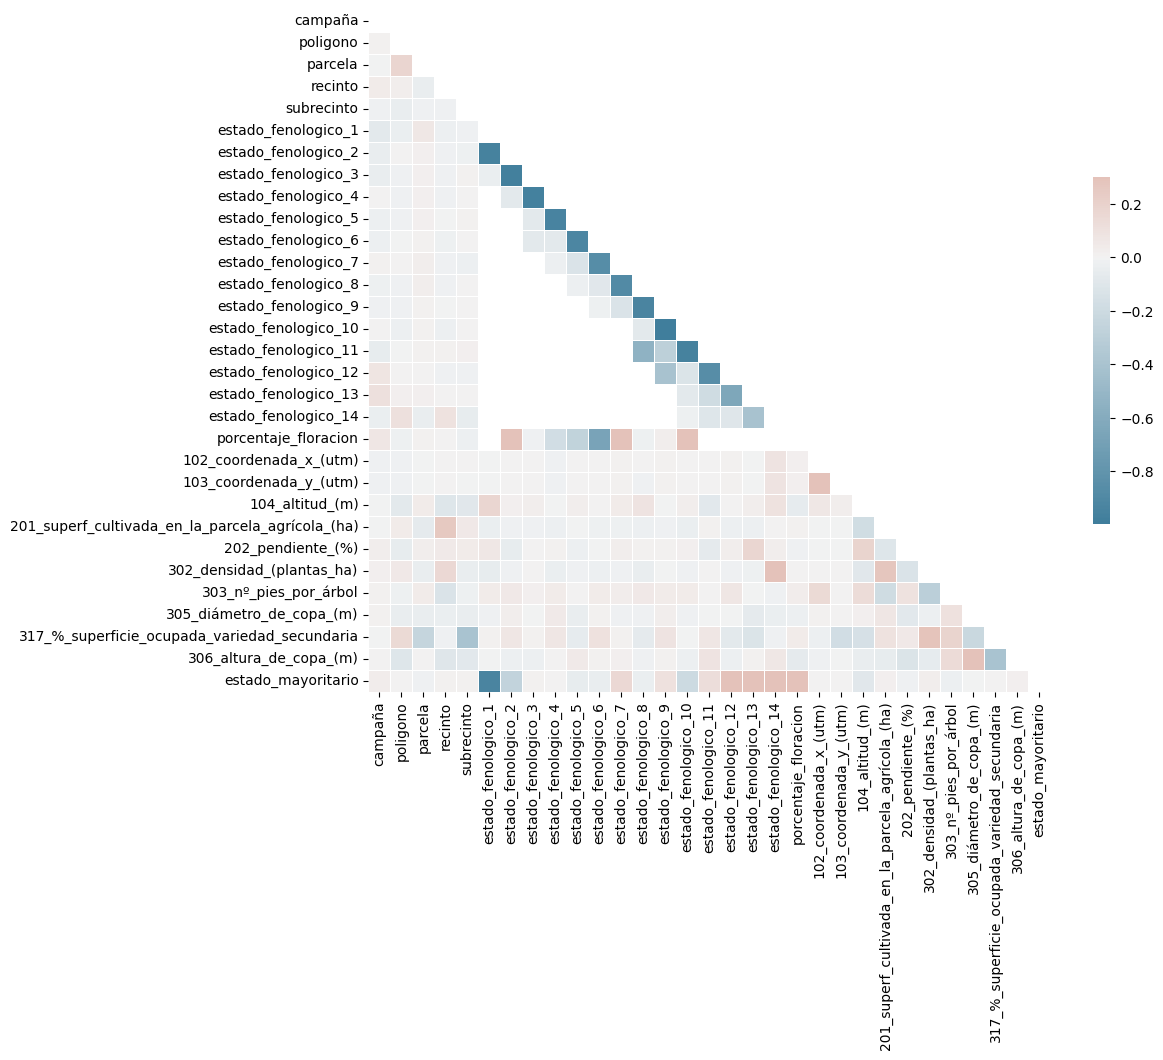

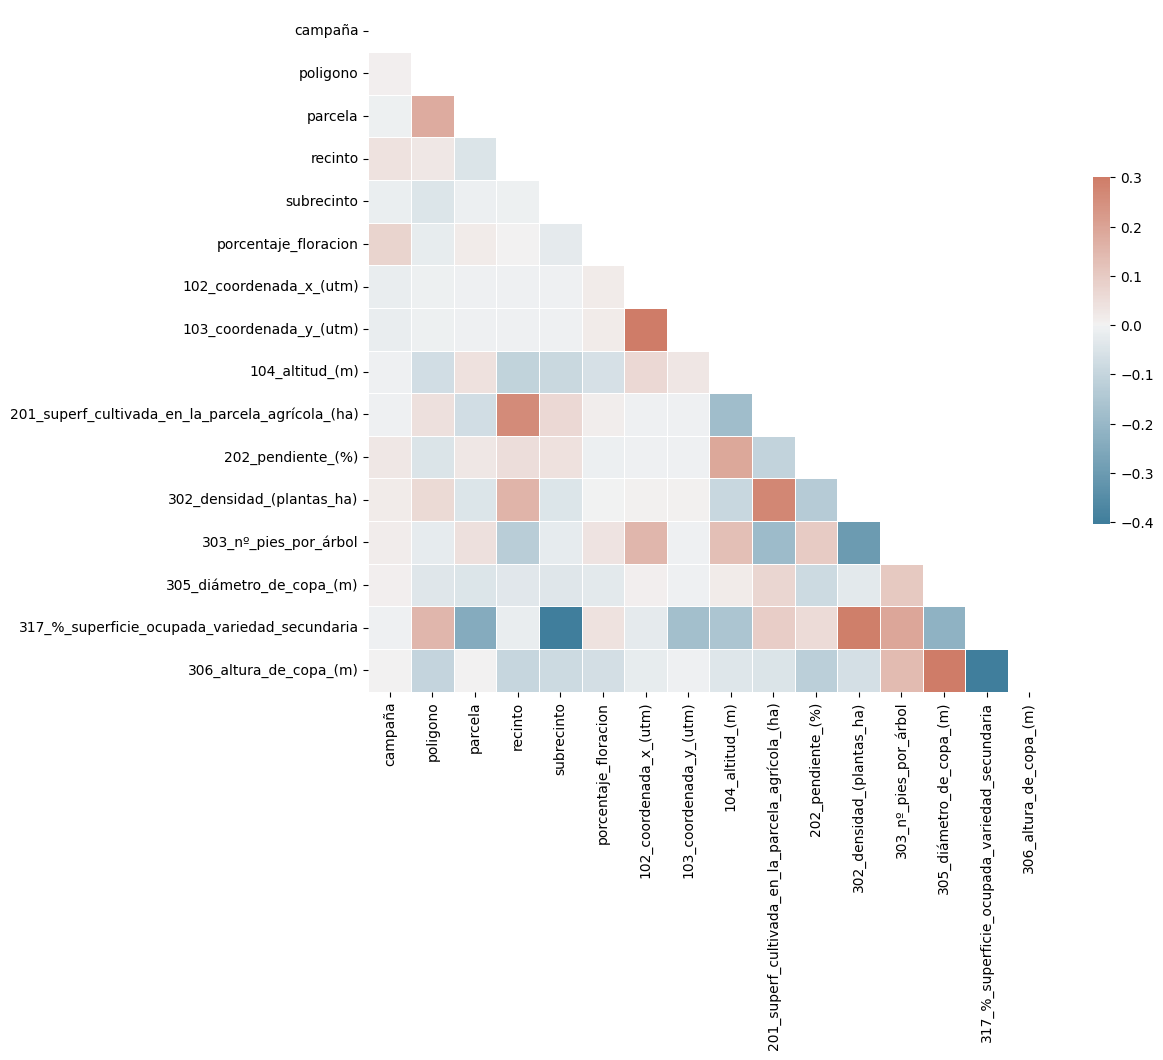

In [10]:
numerical_df = df_parcelas.select_dtypes(include=['number'])
filtered_numerical_df = numerical_df.loc[:, ~numerical_df.columns.str.startswith('estado_')]

def plot_correlation_matrix(df_):
    # Compute the correlation matrix
    corr = df_.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
plot_correlation_matrix(numerical_df)
plot_correlation_matrix(filtered_numerical_df)

### Logistic Regression

In [5]:
SPLIT_YEAR = 2021
MAX_YEAR = 2022
LABEL_COL = 'target'

def preprocess_data(columns_parcela,columns_meteo):
    ### Load data and split in train test
    spine_df = create_spine(df_parcelas)

    if len(columns_parcela) > 0:
        spine_df = attach_parcela_var(spine_df, df_parcelas, columns_parcela)
    if len(columns_meteo) > 0:
        spine_df = attach_meteo_var(spine_df, df_meteo, columns_meteo, window_tolerance=2)

    # Split dataset into train and test
    train_df, test_df = train_test_split(spine_df, split_year=SPLIT_YEAR, max_year=MAX_YEAR)

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)

    ### Apply transformations
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        #StandardScaler(),
    )
    
    #categorical_transformer = make_pipeline(
    #   SimpleImputer(strategy="most_frequent"),
    #    OneHotEncoder(),
    #)
    
    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                parcelas_numerical_cols,
            ),
            
            #(   "categorical", 
            #    categorical_transformer, 
            #    parcelas_categorical_cols
            #,           
        ],
    )

    X_train = features_transformer.fit_transform(X_train) 
    X_test = features_transformer.transform(X_test) 

    return X_train, y_train.array, X_test, y_test.array


In [8]:
X_train, y_train, X_test, y_test = preprocess_data(columns_parcela=parcelas_numerical_cols,
                                                    columns_meteo = [])

In [9]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-4, multi_class='multinomial', solver='saga')),
    ]
)
lr.fit(X_train, y_train)
train_preds_proba = lr.predict_proba(X_train)[:, 1]
test_preds_proba = lr.predict_proba(X_test)[:, 1]

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [10]:
evaluate_classification(y_train, train_preds)
evaluate_classification(y_test, test_preds)

accuracy: 0.6152360954168928

precision_macro: 0.1440989231098046

recall_macro: 0.16421547737743897

f1_macro: 0.151172537636368

mse: 0.5664065628030714

confusion_matrix: [[53793  5121     0     0     0     0     0     0]
 [22969 15354     0     0     0     0     0     0]
 [ 4102  8894     0     0     0     0     0     0]
 [   70  1909     0     0     0     0     0     0]
 [    3   145     0     0     0     0     0     0]
 [    2    18     0     0     0     0     0     0]
 [    1     9     0     0     0     0     0     0]
 [    0     1     0     0     0     0     0     0]]

-----------------------------------------------------------------

accuracy: 0.579009848751319

precision_macro: 0.1505581316401412

recall_macro: 0.1772898286913916

f1_macro: 0.16016581926810658

mse: 0.674243756595146

confusion_matrix: [[10635  1145     0     0     0     0     0]
 [ 4958  2534     0     0     0     0     0]
 [ 1012  1720     0     0     0     0     0]
 [   22   664     0     0     0     0    

### Random Forest

In [17]:
X_train, y_train, X_test, y_test = preprocess_data(columns_parcela=parcelas_numerical_cols,
                                                    columns_meteo = [])

In [21]:
rf = RandomForestClassifier(500)
rf.fit(X_train, y_train)

train_preds_proba = rf.predict_proba(X_train)[:, 1]
test_preds_proba = rf.predict_proba(X_test)[:, 1]

train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

evaluate_classification(y_train, train_preds)
evaluate_classification(y_test, test_preds)

accuracy: 0.8052157201199385

precision_macro: 0.8249142453615488

recall_macro: 0.661458834418324

f1_macro: 0.716607641282248

mse: 0.28045839969392566

confusion_matrix: [[54303  3980   544    74    13     0     0     0]
 [12853 24798   601    67     4     0     0     0]
 [ 1213  1729  9981    67     4     2     0     0]
 [  202   252   201  1312    11     0     1     0]
 [   27    10    10     6    95     0     0     0]
 [    8     4     3     0     0     5     0     0]
 [    2     1     3     0     0     0     4     0]
 [    0     0     0     0     0     0     0     1]]

-----------------------------------------------------------------

accuracy: 0.6606577558916638

precision_macro: 0.2840574605028389

recall_macro: 0.24602073261314544

f1_macro: 0.25542471163740227

mse: 0.50787020752726

confusion_matrix: [[10060  1485   216    18     0     1     0     0]
 [ 2956  3708   750    77     1     0     0     0]
 [  290  1173  1213    55     1     0     0     0]
 [   57   319   263    

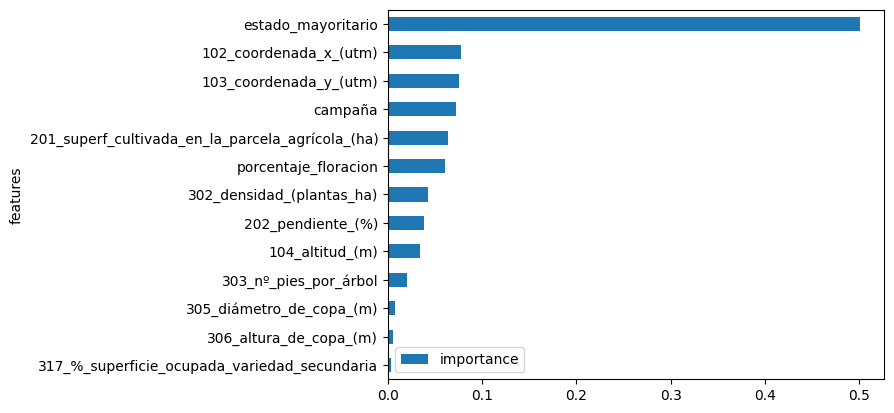

In [22]:
rf_fi, fig, ax = plot_feature_importance(rf, parcelas_numerical_cols)

### XGBoost

accuracy: 0.6982320648450498

precision_macro: 0.6908264075803443

recall_macro: 0.4592445264997421

f1_macro: 0.4842432477541744

mse: 0.37838439020918047

confusion_matrix: [[53073  5565   253    14     0     9     0     0]
 [16113 19678  2507     6     2    17     0     0]
 [  696  6676  5580    25    11     8     0     0]
 [   50  1156   670   100     1     2     0     0]
 [    1    89    23     0    34     1     0     0]
 [    1    11     1     0     0     7     0     0]
 [    0     7     1     0     0     0     2     0]
 [    0     0     0     0     0     0     0     1]]

-----------------------------------------------------------------

accuracy: 0.6629880408019697

precision_macro: 0.334505831542235

recall_macro: 0.24777282189704683

f1_macro: 0.25450530149198214

mse: 0.4805223355610271

confusion_matrix: [[10462  1297    20     0     0     1     0]
 [ 3467  3656   363     0     0     6     0]
 [  248  1519   955     6     1     3     0]
 [   16   552   110     6     2     0 

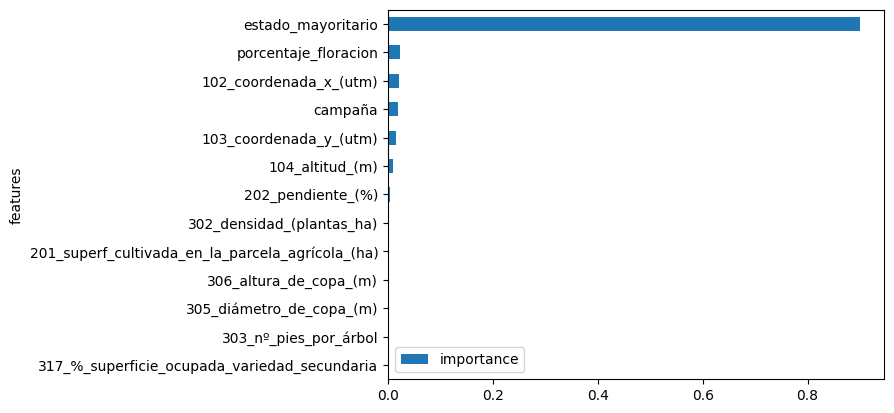

In [20]:
X_train, y_train, X_test, y_test = preprocess_data(columns_parcela=parcelas_numerical_cols,
                                                    columns_meteo = [])


lr_best = 0.05
max_depth_best = 5
n_estimators_best = 50

gbt = GradientBoostingClassifier(
    learning_rate=lr_best, max_depth=max_depth_best, n_estimators=n_estimators_best
)
gbt.fit(X_train, y_train)
train_preds = gbt.predict(X_train)
test_preds = gbt.predict(X_test)

evaluate_classification(y_train, train_preds)
evaluate_classification(y_test, test_preds)


gbt_fi, fig, ax = plot_feature_importance(gbt, parcelas_numerical_cols)


# Functions